# Training and Running of new GLM model
This Notebook is for training and running the our new GLM model that includes (for now only) deletion tokens

## Adding necessary imports
You can run this block to import necessary classes and functions

In [22]:
from fundemental_classes.model_related.glm_model import GLMModel

# You can change force_retrain to True if you want to always retrain your model everytime
model = GLMModel("./dna_bert_final", "simulated_sequences/augumented_sequence_size20000_length40_deletions0.2_nodeletionseq0.1.fasta", force_retrain=False)

loading file tokenizer.json
loading file tokenizer.model
loading file added_tokens.json
loading file special_tokens_map.json
loading file tokenizer_config.json
loading file chat_template.jinja
loading configuration file ./dna_bert_final/config.json
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "dtype": "float32",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 256,
  "initializer_range": 0.02,
  "intermediate_size": 1536,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 8,
  "num_hidden_layers": 8,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.57.3",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 10
}

loading weights file ./dna_bert_final/model.safetensors


Checking for existing trained model in ./dna_bert_final
Loading tokenizer...
Tokenizer loaded
Loading dataset...
Dataset loaded
Loading model...
Model loaded successfully!
Trained for 20 epochs
Final validation loss: 0.9374


## Training
We use `Bert` model to create the embeddings and train it using masking to get nicely trained model. If you want to change the size of training data, please look into `simulated_sequences` directory. \\\
*important:* Training is not necessary if you already have a trained model. You can load it using the `GLMModel`.

PyTorch: setting up devices
***** Running training *****
  Num examples = 16,000
  Num Epochs = 20
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 20,000
  Number of trainable parameters = 8,620,042


Dataset split: 16000 training, 4000 validation
Starting Training


Step,Training Loss,Validation Loss
500,1.466600,1.452208
1000,1.371200,1.328004
1500,1.291200,1.270106
2000,1.248600,1.214841
2500,1.203000,1.195518
3000,1.180900,1.176010
3500,1.154500,1.124155
4000,1.127200,1.112851
4500,1.100700,1.073260
5000,1.070000,1.050721



***** Running Evaluation *****
  Num examples = 4000
  Batch size = 16
Saving model checkpoint to ./dna_bert_final/checkpoint-500
Configuration saved in ./dna_bert_final/checkpoint-500/config.json
Model weights saved in ./dna_bert_final/checkpoint-500/model.safetensors
Saving Trainer.data_collator.tokenizer by default as Trainer.processing_class is `None`
tokenizer config file saved in ./dna_bert_final/checkpoint-500/tokenizer_config.json
Special tokens file saved in ./dna_bert_final/checkpoint-500/special_tokens_map.json

***** Running Evaluation *****
  Num examples = 4000
  Batch size = 16
Saving model checkpoint to ./dna_bert_final/checkpoint-1000
Configuration saved in ./dna_bert_final/checkpoint-1000/config.json
Model weights saved in ./dna_bert_final/checkpoint-1000/model.safetensors
Saving Trainer.data_collator.tokenizer by default as Trainer.processing_class is `None`
tokenizer config file saved in ./dna_bert_final/checkpoint-1000/tokenizer_config.json
Special tokens file sav

Saving model and tokenizer...
Training complete
Metadata saved to ./dna_bert_final/training_metadata.json
Training curves saved to ./dna_bert_final/training_curves.png


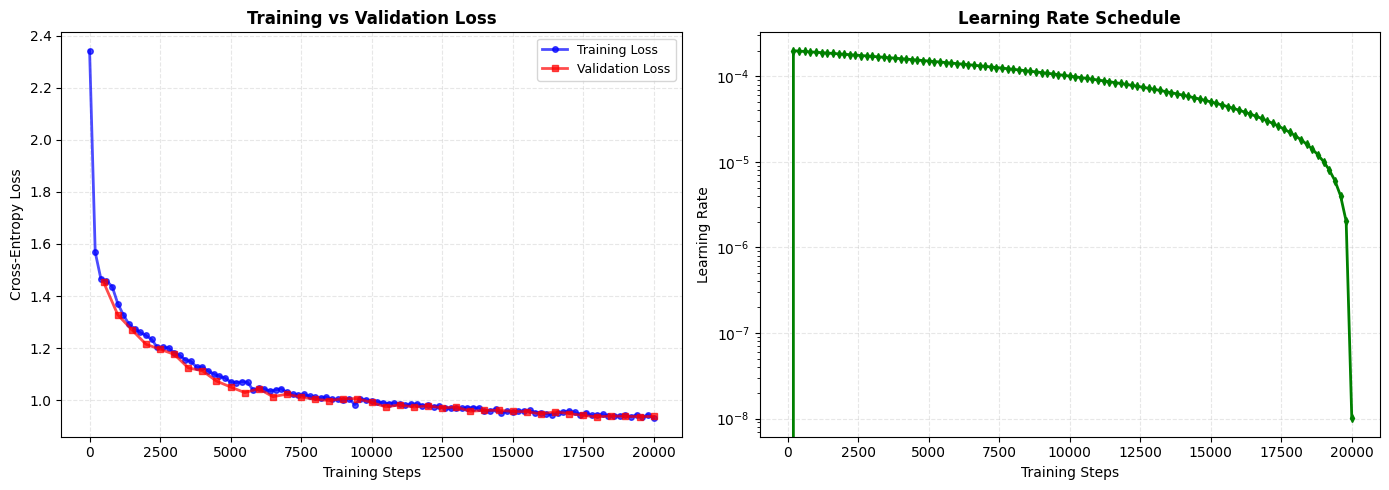


Training Summary:
Final training loss: 0.9302
Final validation loss: 0.9374
Best validation loss: 0.9360


In [5]:
model.train(epochs=20, batch_size=16, lr=2e-4)

In [9]:
## Visualization functions

import seaborn as sns
import matplotlib.pyplot as plt

def plot_map_with_seq(matrix, dna_sequence,  plot_size=10, vmax=5, tick_label_fontsize=8):

    fig, ax = plt.subplots(figsize=(plot_size, plot_size))
    
   
    sns.heatmap(matrix, cmap='coolwarm', vmax=vmax, ax=ax, 
                xticklabels=False, yticklabels=False)  
    ax.set_aspect('equal')

    tick_positions = np.arange(len(dna_sequence)) + 0.5 # Center the ticks

    ax.set_xticks(tick_positions)
    ax.set_yticks(tick_positions)
    ax.set_xticklabels(list(dna_sequence), fontsize=tick_label_fontsize, rotation=0)
    ax.set_yticklabels(list(dna_sequence), fontsize=tick_label_fontsize)

    plt.show()
    
def plot_map(matrix, vmax=None, display_values=False, annot_size=8, fig_size=10):
   
    plt.figure(figsize=(fig_size, fig_size))

    ax = sns.heatmap(matrix, cmap="coolwarm", vmax=vmax, annot=display_values, 
                     fmt=".2f", annot_kws={"size": annot_size})

    ax.set_aspect('equal')

    plt.show()

In [ ]:
#dependency map generation functions
from datasets import Dataset
from transformers import BertForMaskedLM, AutoTokenizer, DefaultDataCollator
import torch
import pandas as pd
import numpy as np

nuc_table = {"-" : 0, "A" : 1, "C":2, "G":3, "T":4}

tokenizer = model.tokenizer
device = model.device
model_GLM = model.model.to(device)


def mutate_sequence(seq):
    
    seq = seq.upper()
    mutated_sequences = {'seq':[], 'mutation_pos':[], 'nuc':[], 'var_nt_idx':[]}
    mutated_sequences['seq'].append(seq)
    mutated_sequences['mutation_pos'].append(-1)
    mutated_sequences['nuc'].append('real sequence')
    mutated_sequences['var_nt_idx'].append(-1)


    mutate_until_position = len(seq)

    for i in range(mutate_until_position):
        for nuc in ['-', 'A', 'C', 'G', 'T']:
            if nuc != seq[i]:
                mutated_sequences['seq'].append(seq[:i] + nuc + seq[i+1:])
                mutated_sequences['mutation_pos'].append(i)
                mutated_sequences['nuc'].append(nuc)
                mutated_sequences['var_nt_idx'].append(nuc_table[nuc])

    mutations_df = pd.DataFrame(mutated_sequences)

    return mutations_df

def tok_func_no_species(x):
    ids = tokenizer.encode(x["seq"], add_special_tokens=True)
    return {
        "input_ids": ids,
        "attention_mask": [1] * len(ids),
    }

def create_dataloader(dataset, batch_size=64, rolling_masking=False):
    ds = Dataset.from_pandas(dataset[['seq']])
    tok_ds = ds.map(lambda x: tok_func_no_species(x), batched=False, num_proc=1)
    rem_tok_ds = tok_ds.remove_columns('seq')
    
    data_collator = DefaultDataCollator()
    data_loader = torch.utils.data.DataLoader(
        rem_tok_ds,
        batch_size=batch_size,
        num_workers=4,
        shuffle=False,
        collate_fn=data_collator
    )
    return data_loader

acgt_idxs = [tokenizer.get_vocab()[nuc] for nuc in ['-', 'A', 'C', 'G', 'T']]

def model_inference(model_GLM, data_loader):

    output_arrays = []
    for i, batch in enumerate(data_loader):
        # get some tokenized sequences (B, L_in)
        tokens = batch['input_ids']
        # predict
        with torch.autocast(device_type=device.type):
            with torch.no_grad():
                outputs = model_GLM(tokens.to(device)).logits.cpu().to(torch.float32)
        output_probs = torch.nn.functional.softmax(outputs, dim=-1)[:,:,acgt_idxs] # B, L_seq, 5
        output_arrays.append(output_probs) 

    # rebuild to B, L_seq, 5
    snp_reconstruct = torch.concat(output_arrays, axis=0)

    return snp_reconstruct.to(torch.float32).numpy()

def compute_dependency_map(seq, epsilon=1e-10):

    dataset = mutate_sequence(seq) 
    data_loader = create_dataloader(dataset, batch_size=16)
    snp_reconstruct = model_inference(model_GLM, data_loader)
    snp_reconstruct = snp_reconstruct[:,1:-1,:] # discard the beginning of sentence token, species token and end of sentence token

    if snp_reconstruct.shape[1] != len(seq):
        raise ValueError(f"Length mismatch: len(seq)={len(seq)} but model positions={snp_reconstruct.shape[1]}. "
                        f"Check tokenizer.encode/add_special_tokens and slicing.")
    
     # for the logit add a small value epsilon and renormalize such that every prob in one position sums to 1
    snp_reconstruct = snp_reconstruct + epsilon
    snp_reconstruct = snp_reconstruct/snp_reconstruct.sum(axis=-1)[:,:, np.newaxis]

    seq_len = snp_reconstruct.shape[1]
    snp_effect = np.zeros((seq_len, seq_len,5, 5))
    reference_probs = snp_reconstruct[dataset[dataset['nuc'] == 'real sequence'].index[0]]

    
    snp_effect[dataset.iloc[1:]['mutation_pos'].values, : ,  dataset.iloc[1:]['var_nt_idx'].values,:] = np.log2(snp_reconstruct[1:]) - np.log2(1 - snp_reconstruct[1:]) \
        - np.log2(reference_probs) + np.log2(1-reference_probs)

    dep_map = np.max(np.abs(snp_effect), axis=(2,3))
    #zero main diagonal values
    dep_map[np.arange(dep_map.shape[0]), np.arange(dep_map.shape[0])] = 0

    return dep_map

In [55]:

header = "seq94229|label=both|posAmotif=14|posBmotif=32|gaplength=10|deletions=3"
sequence = "ATCGT-GCGACGAAATATTCA-TGGCCTTGTTGTACTGC-"
dep_map = compute_dependency_map(sequence)


Map (num_proc=1): 100%|██████████| 161/161 [00:00<00:00, 1471.04 examples/s]


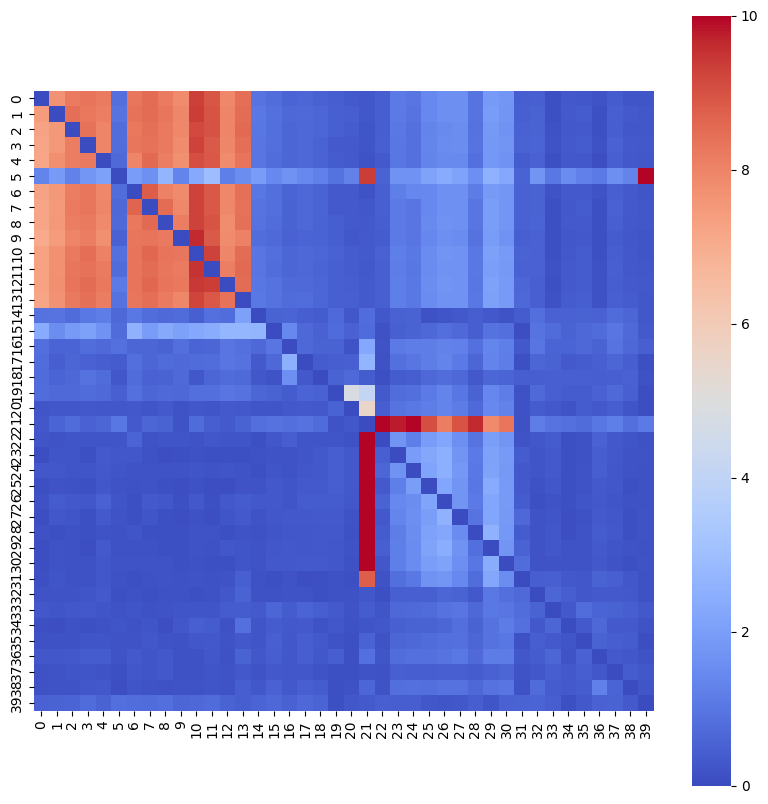

In [56]:

plot_map(dep_map, vmax=10)

## Visualization
This block is used for getting already trained model, passing the sequence to test how well the model performs.
\\\\\
*Important:* For now we pass our test cases by hand. However in the future we will generate good inputs to test how well the model functions

In [ ]:
from fundemental_classes.visualization.sequence_plotter import plot


header = "seq94229|label=both|posAmotif=14|posBmotif=32|gaplength=10|deletions=3"
sequence = "ATCGT-GCGACGAAATATTCA-TTTTTTTGTACTGCT"
prob_matrix = model.get_full_reconstruction_probs(sequence)

plot(header, sequence, prob_matrix, motif_length=7)

UnboundLocalError: local variable 'probs' referenced before assignment